## Import libraries

In [18]:
import numpy as np
import pandas as pd
from os import path
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
import sklearn
from sklearn import preprocessing, metrics
from sklearn.metrics import (roc_curve, auc, accuracy_score, precision_score, 
                             recall_score, f1_score, balanced_accuracy_score, 
                             matthews_corrcoef)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
import shap
from imblearn.over_sampling import RandomOverSampler
import innvestigate
import matplotlib.pyplot as plt 

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

tf.compat.v1.disable_eager_execution()

In [19]:
output_file_name = "Completeness_example.txt"
with open(output_file_name, "w") as f: print('---------------------------------------------------------------------------------', file = f)


#### Function definition

In [20]:

def confusion_metrics (name_model,predictions,true_labels,time_taken):

    name = name_model
    pred_label = predictions
    y_test_01 = true_labels 

    with open(output_file_name, "a") as f: print('--------------------------------------------------------------------------', file = f)

    with open(output_file_name, "a") as f: print(name, file = f)


    print('---------------------------------------------------------------------------------')
    print('CONFUSION MATRIX')
    print('---------------------------------------------------------------------------------')


    # pred_label = label[ypred]

    confusion_matrix = pd.crosstab(y_test_01, pred_label,rownames=['Actual ALERT'],colnames = ['Predicted ALERT'], dropna=False).sort_index(axis=0).sort_index(axis=1)
    all_unique_values = sorted(set(pred_label) | set(y_test_01))
    z = np.zeros((len(all_unique_values), len(all_unique_values)))
    rows, cols = confusion_matrix.shape
    z[:rows, :cols] = confusion_matrix
    confusion_matrix  = pd.DataFrame(z, columns=all_unique_values, index=all_unique_values)
    # confusion_matrix.to_csv('Ensemble_conf_matrix.csv')
    # with open(output_file_name, "a") as f:print(confusion_matrix,file=f)
    print(confusion_matrix)
    with open(output_file_name, "a") as f: print('Confusion Matrix', file = f)

    with open(output_file_name, "a") as f: print(confusion_matrix, file = f)


    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.values.sum() - (FP + FN + TP)
    TP_total = sum(TP)
    TN_total = sum(TN)
    FP_total = sum(FP)
    FN_total = sum(FN)

    TP_total = np.array(TP_total,dtype=np.float64)
    TN_total = np.array(TN_total,dtype=np.float64)
    FP_total = np.array(FP_total,dtype=np.float64)
    FN_total = np.array(FN_total,dtype=np.float64)
    FPR = FP / (FP + TN)
    FPR = 100*(sum(FPR)/len(FPR))

    #----------------------------------------------------------------#----------------------------------------------------------------

    print('---------------------------------------------------------------------------------')
    print('METRICS')
    print('---------------------------------------------------------------------------------')


    Acc = accuracy_score(y_test_01, pred_label)
    Precision = precision_score(y_test_01, pred_label, average='macro')
    Recall = recall_score(y_test_01, pred_label, average='macro')
    F1 =  f1_score(y_test_01, pred_label, average='macro')
    BACC = balanced_accuracy_score(y_test_01, pred_label)
    MCC = matthews_corrcoef(y_test_01, pred_label)

    print('Accuracy total: ', Acc)
    print('Precision total: ', Precision )
    print('Recall total: ', Recall )
    print('F1 total: ', F1 )
    print('BACC total: ', BACC)
    print('MCC total: ', MCC)

    with open(output_file_name, "a") as f: print('Accuracy total: ', Acc, file = f)
    with open(output_file_name, "a") as f: print('Precision total: ', Precision, file = f)
    with open(output_file_name, "a") as f: print('Recall total: ', Recall , file = f)
    with open(output_file_name, "a") as f: print('F1 total: ', F1, file = f)
    with open(output_file_name, "a") as f: print('BACC total: ', BACC , file = f)
    with open(output_file_name, "a") as f: print('MCC total: ', MCC, file = f)
    with open(output_file_name, "a") as f: print('Time Taken: ', time_taken, file = f)
    with open(output_file_name, "a") as f: print('FPR: ', FPR, '%' ,file = f)

    return Acc, Precision, Recall, F1, BACC, MCC, FPR



## LOAD NSL KDD DATASET

In [21]:
# attach the column names to the dataset
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]
# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.

train='KDDTrain+.txt'
test='KDDTest+.txt'

df=pd.read_csv(train,names=feature)
df_test=pd.read_csv(test,names=feature)



# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)


df.drop(['difficulty'],axis=1,inplace=True)
df_test.drop(['difficulty'],axis=1,inplace=True)



print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())



# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())



# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))



categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()


# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2




df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)



enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()


trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)


# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())


# Specify your selected features. Note that you'll need to modify this list according to your final processed dataframe
#Uncomment the below lines to use these top 20 features from shap analysis
#selected_features = ["root_shell","service_telnet","num_shells","service_uucp","dst_host_same_src_port_rate"
#                     ,"dst_host_rerror_rate","dst_host_srv_serror_rate","dst_host_srv_count","service_private","logged_in",
#                    "dst_host_serror_rate","serror_rate","srv_serror_rate","flag_S0","diff_srv_rate","dst_host_srv_diff_host_rate","num_file_creations","flag_RSTR"#,"dst_host_same_srv_rate","service_Idap","label"]
                     

# Select those features from your dataframe
#newdf = newdf[selected_features]
#newdf_test = newdf_test[selected_features]

# Now your dataframe only contains your selected features.

# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = newdf.copy()
multi_label = pd.DataFrame(multi_data.label)

multi_data_test=newdf_test.copy()
multi_label_test = pd.DataFrame(multi_data_test.label)


# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)
numeric_col_test = multi_data_test.select_dtypes(include='number').columns
data_test = standardization(multi_data_test,numeric_col_test)

# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
le2_test = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
enc_label_test = multi_label_test.apply(le2_test.fit_transform)
multi_data = multi_data.copy()
multi_data_test = multi_data_test.copy()

multi_data['intrusion'] = enc_label
multi_data_test['intrusion'] = enc_label_test


multi_data.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data_test.drop(labels= [ 'label'], axis=1, inplace=True)

y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

y_test_multi= multi_data_test[['intrusion']]
X_test_multi= multi_data_test.drop(labels=['intrusion'], axis=1)

print('X_test has shape:',X_test_multi.shape,'\ny_test has shape:',y_test_multi.shape)

label_counts = Counter(y_train_multi['intrusion'])
print(label_counts)

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)

y_test_multi = LabelBinarizer().fit_transform(y_test_multi)


Y_train=y_train_multi.copy()
X_train=X_train_multi.copy()

Y_test=y_test_multi.copy()
X_test=X_test_multi.copy()

# Assuming you have features X and labels Y
# X, Y = make_classification()

ros = RandomOverSampler(sampling_strategy='minority', random_state=100)

X_train, Y_train = ros.fit_resample(X_train, Y_train)

single_class_train = np.argmax(y_train_multi, axis=1)
single_class_test = np.argmax(y_test_multi, axis=1)


df1 = X_train_multi.assign(Label = single_class_train)
df2 =  X_test_multi.assign(Label = single_class_test)

frames = [df1,  df2]

df = pd.concat(frames,ignore_index=True)


Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)
Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess  

#### Replace One hot encoded to Label encoding

In [22]:

df_fs = df

y = df.pop('Label')
X = df



#-----------------------------------
print('---------------------------------------------------------------------------------')
print('Separating datasets')
print('---------------------------------------------------------------------------------')
print('')

test2 = X.assign(ALERT = y)


# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)

Dos_samples = test2[test2['ALERT'] == 0]
Normal_samples = test2[test2['ALERT'] == 1]
Probe_samples = test2[test2['ALERT'] == 2]
R2L_samples = test2[test2['ALERT'] == 3]
U2R_samples = test2[test2['ALERT'] == 4]

Probe_y = Probe_samples.pop('ALERT')
Dos_y = Dos_samples.pop('ALERT')
Normal_y = Normal_samples.pop('ALERT')
U2R_y = U2R_samples.pop('ALERT')
R2L_y = R2L_samples.pop('ALERT')


test2.pop('ALERT')
#------------------------------------

df = X.assign(Label = y)

y1, y2 = pd.factorize(y)

y_0 = pd.DataFrame(y1)
y_1 = pd.DataFrame(y1)
y_2 = pd.DataFrame(y1)
y_3 = pd.DataFrame(y1)
y_4 = pd.DataFrame(y1)


# y_0 = y_0.replace(0, 0)
# y_0 = y_0.replace(1, 1)
y_0 = y_0.replace(2, 1)
y_0 = y_0.replace(3, 1)
y_0 = y_0.replace(4, 1)


y_1 = y_1.replace(1, 999)
y_1 = y_1.replace(0, 1)
# y_1 = y_1.replace(1, 0)
y_1 = y_1.replace(2, 1)
y_1 = y_1.replace(3, 1)
y_1 = y_1.replace(4, 1)
y_1 = y_1.replace(999, 1)


y_2 = y_2.replace(0, 1)
y_2 = y_2.replace(1, 1)
y_2 = y_2.replace(2, 0)
y_2 = y_2.replace(3, 1)
y_2 = y_2.replace(4, 1)


y_3 = y_3.replace(0, 1)
# y_3 = y_3.replace(1, 1)
y_3 = y_3.replace(2, 1)
y_3 = y_3.replace(3, 0)
y_3 = y_3.replace(4, 1)


y_4 = y_4.replace(0, 1)
# y_4 = y_4.replace(1, 1)
y_4 = y_4.replace(2, 1)
y_4 = y_4.replace(3, 1)
y_4 = y_4.replace(4, 0)



df = df.assign(Label = y)

---------------------------------------------------------------------------------
Separating datasets
---------------------------------------------------------------------------------



#### NSL KDD dataset display

In [23]:
X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,-0.046432
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,-0.046432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.453815,-0.18843,-0.009419,-0.174880,-0.313124,-0.030535,-0.025803,-0.105681,0.718027,-0.056997
148513,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.453815,-0.18843,-0.009419,-0.174880,-0.313124,-0.030535,-0.025803,-0.105681,0.718027,-0.056997
148514,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,-0.453815,-0.18843,-0.009419,-0.174880,-0.313124,-0.030535,-0.025803,-0.105681,0.718027,-0.056997
148515,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.453815,-0.18843,-0.009419,-0.174880,-0.313124,-0.030535,-0.025803,-0.105681,0.718027,-0.056997


In [24]:
y

0         0
1         0
2         1
3         0
4         0
         ..
148512    0
148513    0
148514    1
148515    0
148516    2
Name: Label, Length: 148517, dtype: int64

#### Separate Training and Testing db


In [25]:

X_train,X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.7,random_state=42)
df = X.assign( Label = y)


In [26]:
train = X_train
test = X_test
labels_train = y_train
labels_test = y_test

In [27]:
label = ['Dos','normal','Probe','R2L','U2R']
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)


#### Training model

In [28]:

nodes = 5
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(len(X_train.columns,))))

model.add(tf.keras.layers.Dense(nodes, activation='relu'))
# model.add(tf.keras.layers.Dense(nodes, activation='relu'))

model.add(tf.keras.layers.Dense(5))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

start = time.time()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

# Modify model.fit to include the EarlyStopping callback
model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), callbacks=[early_stopping])

end = time.time()
print('---------------------------------------------------------------------------------')
print('ELAPSE TIME TRAINING MODEL: ',(end - start)/60, 'min')
print('---------------------------------------------------------------------------------')
print('')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 615       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________
Train on 103961 samples
Epoch 1/1000
103961/103961 [==============================] - 0s 1us/sample - loss: 3.8330 - accuracy: 0.5472
Epoch 2/1000
103961/103961 [==============================] - 0s 1us/sample - loss: 2.8504 - accuracy: 0.4154
Epoch 3/1000
103961/103961 [==============================] - 0s 1us/sample - loss: 1.7917 - accuracy: 0.5400
Epoch 4/1000
103961/103961 [==============================] - 0s 1us/sample - loss: 1.5331 - accuracy: 0.5823
Epoch 5/1000
103961/103961 [==========================

In [29]:

print('---------------------------------------------------------------------------------')
print('Model Prediction')
print('---------------------------------------------------------------------------------')
print('')
print('---------------------------------------------------------------------------------')
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
print('ELAPSE TIME MODEL PREDICTION: ',(end - start)/60, 'min')
print('---------------------------------------------------------------------------------')
print('')

ynew = np.argmax(y_pred,axis = 1)
score = model.evaluate(X_test, y_test,verbose=1)
label = y2

label_counts = Counter(y_test)
print(label_counts)

label_counts = Counter(ynew)
print(label_counts)

accuracy =accuracy_score(y_test, ynew)*100
print('accuracy (%)', accuracy)

---------------------------------------------------------------------------------
Model Prediction
---------------------------------------------------------------------------------

---------------------------------------------------------------------------------
ELAPSE TIME MODEL PREDICTION:  0.009143328666687012 min
---------------------------------------------------------------------------------

Counter({0: 23102, 1: 16081, 2: 4144, 3: 1197, 4: 32})
Counter({0: 26708, 1: 16706, 2: 1142})
accuracy (%) 84.29392225513959


#### Here are the two functions that are used to generate the completeness experiment

In [30]:
explainer = shap.DeepExplainer(model,train.values.astype('float'))


#### inputs: Single sample
#### outputs: prediction, feature XAI score, feature_val, feature_names

In [31]:
#Define function to test sample with the waterfall plot
def waterfall_explanator(sample):


    shap_values = explainer.shap_values(sample.values.astype('float'))
    index = np.argmax(model.predict(sample)) # Prediction of the sample
    vals= np.abs(shap_values[index])

    feature_importance = pd.DataFrame(list(zip(train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance.head()

    shap_val = list(feature_importance['feature_importance_vals'])
    prediction = index
    feature_name = list(feature_importance['col_name'])
    feature_val = []
    for j in feature_name:
        feature_val.append(float(sample[j]))

    return (prediction, shap_val,feature_val,feature_name)

#### inputs: Dataset of a single class (one vs all), number of samples, number_of_features_pertubation
#### outputs: number of samples changed class, number of all samples analyzed, y_axis for a given class

In [32]:
def completeness_all(single_class_samples,number_samples, number_of_features_pertubation):
    Bucket = {
    '0.0': 0,
    '0.1':0,
    '0.2':0,
    '0.3':0,
    '0.4':0,
    '0.5':0,
    '0.6':0,
    '0.7':0,
    '0.8':0,
    '0.9':0,
    '1.0':0,

           }
    # Counter_chart = 0
    Counter_all_samples = 0
    counter_samples_changed_class = 0
    print('------------------------------------------------')
    print('Initiating Completeness Experiment')
    print('------------------------------------------------')
    for i in range(0,number_samples):
        #select sample
        try:
            sample = single_class_samples[i:i+1]
        except:
            break # break if there more samples requested than samples in the dataset
        # Explanate the original sample
        u = waterfall_explanator(sample)
        #select top 5 features from the original sample
        top_k_features = []
        top_k_features.append(u[3][0]) #append first feature
        break_condition = False
        for k in range(1,number_of_features_pertubation):
            for j in range(11):  # 11 steps to include 1.0 (0 to 10)
                if break_condition == True: break
                perturbation = j / 10.0  # Divide by 10 to get steps of 0.1
                temp_var = sample[top_k_features[k-1]]
                result = np.where((temp_var - perturbation) < 0, True, False)
                if result < 0: 
                    sample[top_k_features[k-1]] = 1 - perturbation
                else: sample[top_k_features[k-1]] = temp_var - perturbation
                # sample[top_k_features[k-1]] = perturbation
                v = waterfall_explanator(sample)
                if v[0] != u[0]: 
                    # print(str(perturbation))
                    Bucket[str(perturbation)] += 1              
                    break_condition = True
                    counter_samples_changed_class += 1     
                    # Bucket[str(perturbation)] = counter_samples_changed_class              
                    break
                else: sample[top_k_features[k-1]] = abs(temp_var - 1) # set the sample feature value as the symetric opposite
            # print(u)
            top_k_features.append(u[3][k]) #append second, third feature .. and so on
            if break_condition == True: break
        Counter_all_samples += 1
        progress  = 100*Counter_all_samples/number_samples
        if progress%10 == 0: print('Progress', progress ,'%')

    dict = Bucket
    temp = 0
    for k in dict:
        dict[k] = dict[k] + temp
        temp = dict[k]
    total = number_samples
    y_axis = []
    for k in dict:
        dict[k] = abs(dict[k] - total)
        y_axis.append(dict[k]/total)    
    return(counter_samples_changed_class,Counter_all_samples,y_axis)
        

#### We are analysing the 10 samples perturbing the top 2 features.

In [33]:
K_samples = 10
K_feat =  2
num_samples = K_samples
num_feat_pertubation = K_feat


In [34]:
# Dos_samples

In [35]:

p = completeness_all(Dos_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of DoS samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')
y_axis_dos = p[2]


------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------
Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(0, 10, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Number of DoS samples that changed classification:  0
Number of all samples analyzed:  10
0.0 % - samples are complete 


In [36]:
with open(output_file_name, "a") as f:print('',file = f)
with open(output_file_name, "a") as f:print('y_axis_dos = [',y_axis_dos ,']',file = f)

In [37]:


p = completeness_all(Normal_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of Normal samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')
y_axis_normal = p[2]
with open(output_file_name, "a") as f:print('y_axis_normal = [',y_axis_normal ,']',file = f)


------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------
Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(0, 10, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Number of Normal samples that changed classification:  0
Number of all samples analyzed:  10
0.0 % - samples are complete 


In [38]:

p = completeness_all(Probe_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of Probe samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')
y_axis_probe = p[2]
with open(output_file_name, "a") as f:print('y_axis_probe = [',y_axis_probe ,']',file = f)


------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------


Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(4, 10, [1.0, 1.0, 1.0, 0.8, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])
Number of Probe samples that changed classification:  4
Number of all samples analyzed:  10
40.0 % - samples are complete 


In [39]:

p = completeness_all(R2L_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of R2L_samples samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')
y_axis_R2L = p[2]
with open(output_file_name, "a") as f:print('y_axis_R2L = [',y_axis_R2L ,']',file = f)


------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------


Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(1, 10, [1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
Number of R2L_samples samples that changed classification:  1
Number of all samples analyzed:  10
10.0 % - samples are complete 


In [40]:

p = completeness_all(U2R_samples,num_samples,num_feat_pertubation)
print(p)
print('Number of U2R samples that changed classification: ',p[0])
print('Number of all samples analyzed: ',p[1])
percentage = 100*p[0]/p[1]
print(percentage,'%','- samples are complete ')
y_axis_U2R = p[2]
with open(output_file_name, "a") as f:print('y_axis_U2R = [',y_axis_U2R ,']',file = f)


------------------------------------------------
Initiating Completeness Experiment
------------------------------------------------
Progress 10.0 %
Progress 20.0 %
Progress 30.0 %
Progress 40.0 %
Progress 50.0 %
Progress 60.0 %
Progress 70.0 %
Progress 80.0 %
Progress 90.0 %
Progress 100.0 %
(1, 10, [1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
Number of U2R samples that changed classification:  1
Number of all samples analyzed:  10
10.0 % - samples are complete 


#### This experiment can be demanding on the memory. Often the program crashed, therefore for each class I saved the results for the y_axi, and copied and pasted it below. In the next run I would run the other classes. 

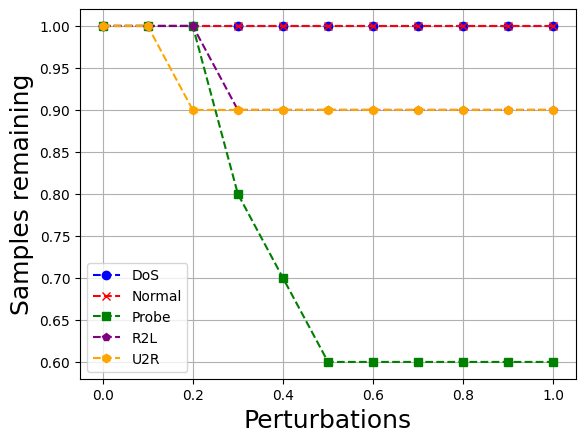

<Figure size 640x480 with 0 Axes>

In [41]:

plt.clf()
x_axis = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]


# y_axis_dos = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
# y_axis_normal = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
# y_axis_probe = [1.0, 1.0, 1.0, 0.8, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6] 
# y_axis_R2L = [1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9] 
# y_axis_U2R = [1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9] 


# Plot the first line
plt.plot(x_axis, y_axis_dos, label='DoS', color='blue', linestyle='--', marker='o')
# plt.plot(x_axis, y_axis_dos)


# Plot the second line
plt.plot(x_axis, y_axis_normal, label='Normal', color='red', linestyle='--', marker='x')

# Plot the third line
plt.plot(x_axis, y_axis_probe, label='Probe', color='green', linestyle='--', marker='s')

# Plot the fourth line
plt.plot(x_axis, y_axis_R2L, label='R2L', color='purple', linestyle='--', marker='p')

# Plot the fifth line
plt.plot(x_axis, y_axis_U2R, label='U2R', color='orange', linestyle='--', marker='h')



# Enable grid lines (both major and minor grids)
plt.grid()

# Customize grid lines (optional)
# plt.grid()

# Add labels and a legend
plt.xlabel('Perturbations', size=18)
plt.ylabel('Samples remaining', size=18)
plt.legend()

# Set the title of the plot
# plt.title('Accuracy x Features - SHAP SML')

# Show the plot
plt.show()
plt.savefig('DNN_DL_NSL_Completeness.png')
plt.clf()